In [1]:
trial_number_ml = "008"
random_state_init = 888

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model2_files = ['../../data_for_ml/ml_datasets_set2/model2_rna_bin_protein_bin/data.pkl']

# Load datasets
model2_df = load_and_concatenate_datasets(model2_files)

# Preprocess datasets
X2, y2 = preprocess_data(model2_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X2, y2)

# Output shapes
print(f"Model 2 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 2 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 18:39:14,530] A new study created in memory with name: no-name-fd9a1a27-ef30-4db7-9b2a-ea520717d4f1


[I 2024-05-01 18:40:05,734] Trial 2 finished with value: 0.8221263929946465 and parameters: {'n_estimators': 348, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 2 with value: 0.8221263929946465.


[I 2024-05-01 18:40:09,707] Trial 3 finished with value: 0.8224463881185302 and parameters: {'n_estimators': 330, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.8224463881185302.


[I 2024-05-01 18:41:07,721] Trial 4 finished with value: 0.8160693424354168 and parameters: {'n_estimators': 459, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 3 with value: 0.8224463881185302.


[I 2024-05-01 18:41:08,581] Trial 0 finished with value: 0.8543189183148956 and parameters: {'n_estimators': 631, 'max_depth': 29, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8543189183148956.


[I 2024-05-01 18:41:22,710] Trial 1 finished with value: 0.8473084854579994 and parameters: {'n_estimators': 716, 'max_depth': 83, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8543189183148956.


[I 2024-05-01 18:41:25,417] Trial 5 finished with value: 0.8441202165808267 and parameters: {'n_estimators': 473, 'max_depth': 56, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.8543189183148956.


[I 2024-05-01 18:41:28,783] Trial 6 pruned. 


[I 2024-05-01 18:41:51,651] Trial 8 finished with value: 0.8399765336909152 and parameters: {'n_estimators': 176, 'max_depth': 71, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8543189183148956.


[I 2024-05-01 18:41:59,288] Trial 10 finished with value: 0.8603785085179654 and parameters: {'n_estimators': 161, 'max_depth': 68, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.8603785085179654.


[I 2024-05-01 18:42:06,663] Trial 7 pruned. 


[I 2024-05-01 18:42:07,084] Trial 9 pruned. 


[I 2024-05-01 18:42:12,815] Trial 11 pruned. 


[I 2024-05-01 18:42:18,111] Trial 12 pruned. 


[I 2024-05-01 18:42:29,263] Trial 13 finished with value: 0.8686648584402524 and parameters: {'n_estimators': 114, 'max_depth': 96, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.8686648584402524.


[I 2024-05-01 18:42:55,832] Trial 17 finished with value: 0.8651560865104277 and parameters: {'n_estimators': 139, 'max_depth': 96, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.8686648584402524.


[I 2024-05-01 18:45:03,980] Trial 15 finished with value: 0.8610129115492843 and parameters: {'n_estimators': 928, 'max_depth': 96, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.8686648584402524.


[I 2024-05-01 18:45:27,836] Trial 14 finished with value: 0.8724890541350481 and parameters: {'n_estimators': 989, 'max_depth': 99, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8724890541350481.


[I 2024-05-01 18:45:43,935] Trial 16 finished with value: 0.8718500797448167 and parameters: {'n_estimators': 1000, 'max_depth': 56, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8724890541350481.


[I 2024-05-01 18:46:06,311] Trial 19 finished with value: 0.8686633346539482 and parameters: {'n_estimators': 231, 'max_depth': 86, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8724890541350481.


[I 2024-05-01 18:46:29,640] Trial 18 finished with value: 0.8718510956023527 and parameters: {'n_estimators': 977, 'max_depth': 99, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8724890541350481.


[I 2024-05-01 18:47:22,784] Trial 23 pruned. 


[I 2024-05-01 18:48:36,396] Trial 20 finished with value: 0.8712126291408893 and parameters: {'n_estimators': 977, 'max_depth': 85, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8724890541350481.


[I 2024-05-01 18:48:59,323] Trial 21 finished with value: 0.8705756864657301 and parameters: {'n_estimators': 990, 'max_depth': 82, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8724890541350481.


[I 2024-05-01 18:49:06,638] Trial 22 finished with value: 0.8613344304594724 and parameters: {'n_estimators': 983, 'max_depth': 56, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8724890541350481.


[I 2024-05-01 18:51:02,855] Trial 24 finished with value: 0.8654755737055435 and parameters: {'n_estimators': 998, 'max_depth': 58, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8724890541350481.


[I 2024-05-01 18:52:01,962] Trial 25 finished with value: 0.8641996566401527 and parameters: {'n_estimators': 848, 'max_depth': 59, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8724890541350481.


[I 2024-05-01 18:52:20,071] Trial 26 finished with value: 0.8648376151728481 and parameters: {'n_estimators': 839, 'max_depth': 59, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8724890541350481.


[I 2024-05-01 18:52:23,789] Trial 28 pruned. 


[I 2024-05-01 18:52:30,653] Trial 27 finished with value: 0.8657935371143551 and parameters: {'n_estimators': 839, 'max_depth': 65, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8724890541350481.


[I 2024-05-01 18:52:38,872] Trial 29 pruned. 


[I 2024-05-01 18:52:45,705] Trial 30 pruned. 


[I 2024-05-01 18:52:47,507] Trial 31 pruned. 


[I 2024-05-01 18:52:55,895] Trial 32 pruned. 


[I 2024-05-01 18:53:07,176] Trial 33 pruned. 


[I 2024-05-01 18:55:14,718] Trial 34 finished with value: 0.8667474273407898 and parameters: {'n_estimators': 923, 'max_depth': 91, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8724890541350481.


[I 2024-05-01 18:55:16,728] Trial 35 finished with value: 0.8708946657320776 and parameters: {'n_estimators': 919, 'max_depth': 90, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8724890541350481.


[I 2024-05-01 18:55:20,668] Trial 36 finished with value: 0.8664284480744421 and parameters: {'n_estimators': 918, 'max_depth': 89, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8724890541350481.


[I 2024-05-01 18:55:29,824] Trial 37 finished with value: 0.8667474273407898 and parameters: {'n_estimators': 923, 'max_depth': 90, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8724890541350481.


[I 2024-05-01 18:55:36,071] Trial 39 pruned. 


[I 2024-05-01 18:55:38,479] Trial 40 pruned. 


[I 2024-05-01 18:55:50,110] Trial 41 pruned. 


[I 2024-05-01 18:56:04,197] Trial 43 pruned. 


[I 2024-05-01 18:56:05,140] Trial 42 pruned. 


[I 2024-05-01 18:57:27,795] Trial 38 finished with value: 0.8731259968102073 and parameters: {'n_estimators': 922, 'max_depth': 89, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 38 with value: 0.8731259968102073.


[I 2024-05-01 18:57:52,388] Trial 47 pruned. 


[I 2024-05-01 18:58:06,130] Trial 48 pruned. 


[I 2024-05-01 18:58:09,345] Trial 45 finished with value: 0.8699382358618027 and parameters: {'n_estimators': 879, 'max_depth': 86, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 38 with value: 0.8731259968102073.


[I 2024-05-01 18:58:09,398] Trial 44 finished with value: 0.8702577230569185 and parameters: {'n_estimators': 966, 'max_depth': 87, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 38 with value: 0.8731259968102073.


[I 2024-05-01 18:58:09,674] Trial 46 finished with value: 0.8702572151281505 and parameters: {'n_estimators': 877, 'max_depth': 85, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 38 with value: 0.8731259968102073.


[I 2024-05-01 18:58:29,728] Trial 49 finished with value: 0.8734454840053232 and parameters: {'n_estimators': 877, 'max_depth': 51, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 49 with value: 0.8734454840053232.


Best trial for RandomForestClassifier:
  Value: 0.8734454840053232
  Params: 
    n_estimators: 877
    max_depth: 51
    min_samples_split: 14
    min_samples_leaf: 1
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 877, 'max_depth': 51, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2024-05-01 18:58:43,113] A new study created in memory with name: no-name-e4b68edd-4c8e-4ba0-a42a-f6cb7a53d18e


RandomForestClassifier accuracy: 0.8548



[I 2024-05-01 18:58:46,418] Trial 2 finished with value: 0.862930850577515 and parameters: {'n_estimators': 157, 'max_depth': 8, 'learning_rate': 0.2939433415182203, 'min_child_weight': 1, 'subsample': 0.7698650234947988, 'colsample_bytree': 0.8080069422171516, 'gamma': 3.30624844768444, 'reg_lambda': 0.053696017957330935, 'reg_alpha': 0.8877557072526289}. Best is trial 2 with value: 0.862930850577515.


[I 2024-05-01 18:58:47,598] Trial 0 finished with value: 0.8476269567955791 and parameters: {'n_estimators': 252, 'max_depth': 5, 'learning_rate': 0.1711183651773778, 'min_child_weight': 4, 'subsample': 0.702856615526485, 'colsample_bytree': 0.7052487896043083, 'gamma': 4.20094639108897, 'reg_lambda': 5.564821774279904, 'reg_alpha': 0.1574922824253469}. Best is trial 2 with value: 0.862930850577515.


[I 2024-05-01 18:58:47,673] Trial 1 finished with value: 0.8530409695344325 and parameters: {'n_estimators': 248, 'max_depth': 3, 'learning_rate': 0.2884437082555472, 'min_child_weight': 1, 'subsample': 0.7432556366100653, 'colsample_bytree': 0.7660484291596564, 'gamma': 2.1202739835753426, 'reg_lambda': 0.2972960380613984, 'reg_alpha': 0.013326135525469076}. Best is trial 2 with value: 0.862930850577515.


[I 2024-05-01 18:58:50,070] Trial 3 finished with value: 0.8533645201596928 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.23836460544415086, 'min_child_weight': 9, 'subsample': 0.9757310154221361, 'colsample_bytree': 0.899127601966534, 'gamma': 3.3483557899082412, 'reg_lambda': 0.18157071044734205, 'reg_alpha': 0.013404704802535201}. Best is trial 2 with value: 0.862930850577515.


[I 2024-05-01 18:58:52,005] Trial 5 finished with value: 0.8371082599376264 and parameters: {'n_estimators': 225, 'max_depth': 3, 'learning_rate': 0.06196770701901981, 'min_child_weight': 8, 'subsample': 0.7802534284774931, 'colsample_bytree': 0.9941775818347538, 'gamma': 3.4612626594447633, 'reg_lambda': 0.6517731260202088, 'reg_alpha': 1.8292135628081372}. Best is trial 2 with value: 0.862930850577515.


[I 2024-05-01 18:58:52,470] Trial 8 pruned. 


[I 2024-05-01 18:58:52,501] Trial 6 finished with value: 0.8562312701266774 and parameters: {'n_estimators': 247, 'max_depth': 5, 'learning_rate': 0.15576204756212106, 'min_child_weight': 5, 'subsample': 0.6386095209379052, 'colsample_bytree': 0.9023911635197598, 'gamma': 2.4534289026323863, 'reg_lambda': 4.803682304496887, 'reg_alpha': 0.3164481884438126}. Best is trial 2 with value: 0.862930850577515.


[I 2024-05-01 18:58:53,192] Trial 10 pruned. 


[I 2024-05-01 18:58:53,262] Trial 9 pruned. 


[I 2024-05-01 18:58:53,868] Trial 12 pruned. 


[I 2024-05-01 18:58:55,192] Trial 7 finished with value: 0.8766317211674235 and parameters: {'n_estimators': 159, 'max_depth': 8, 'learning_rate': 0.10297065892118246, 'min_child_weight': 1, 'subsample': 0.6459005701001175, 'colsample_bytree': 0.8722733373130432, 'gamma': 0.11504700599365203, 'reg_lambda': 0.26531663140128636, 'reg_alpha': 0.20546317401155112}. Best is trial 7 with value: 0.8766317211674235.


[I 2024-05-01 18:58:55,500] Trial 4 finished with value: 0.879497455276872 and parameters: {'n_estimators': 270, 'max_depth': 10, 'learning_rate': 0.08581903234937543, 'min_child_weight': 3, 'subsample': 0.6552153074426703, 'colsample_bytree': 0.5888873622448374, 'gamma': 0.17024756548253694, 'reg_lambda': 1.7312438445544989, 'reg_alpha': 0.4366943364888684}. Best is trial 4 with value: 0.879497455276872.


[I 2024-05-01 18:58:58,194] Trial 11 finished with value: 0.8606944402117047 and parameters: {'n_estimators': 167, 'max_depth': 6, 'learning_rate': 0.12502091413649355, 'min_child_weight': 8, 'subsample': 0.604082301980976, 'colsample_bytree': 0.9392101957345581, 'gamma': 0.04113036171938811, 'reg_lambda': 0.010635032192942312, 'reg_alpha': 0.6005097332650371}. Best is trial 4 with value: 0.879497455276872.


[I 2024-05-01 18:59:03,089] Trial 13 finished with value: 0.8801364296671036 and parameters: {'n_estimators': 472, 'max_depth': 10, 'learning_rate': 0.194741386185665, 'min_child_weight': 1, 'subsample': 0.8275086774669725, 'colsample_bytree': 0.5228298991535355, 'gamma': 0.1316534857330538, 'reg_lambda': 0.01658741121067915, 'reg_alpha': 0.7091387605282347}. Best is trial 13 with value: 0.8801364296671036.


[I 2024-05-01 18:59:08,382] Trial 15 finished with value: 0.8763096943284674 and parameters: {'n_estimators': 422, 'max_depth': 10, 'learning_rate': 0.09745566149698352, 'min_child_weight': 2, 'subsample': 0.5240043132086959, 'colsample_bytree': 0.5153781591094536, 'gamma': 0.060134804958186655, 'reg_lambda': 1.9033266734259238, 'reg_alpha': 0.1675557546663163}. Best is trial 13 with value: 0.8801364296671036.


[I 2024-05-01 18:59:09,040] Trial 14 finished with value: 0.8772666321275105 and parameters: {'n_estimators': 455, 'max_depth': 10, 'learning_rate': 0.09844658529276465, 'min_child_weight': 1, 'subsample': 0.5009354514312814, 'colsample_bytree': 0.5154328820047804, 'gamma': 0.024068792252022103, 'reg_lambda': 0.06780301956224478, 'reg_alpha': 0.6356868486449375}. Best is trial 13 with value: 0.8801364296671036.


[I 2024-05-01 18:59:10,419] Trial 18 pruned. 


[I 2024-05-01 18:59:13,565] Trial 16 finished with value: 0.8798199900445962 and parameters: {'n_estimators': 501, 'max_depth': 10, 'learning_rate': 0.08000273168059559, 'min_child_weight': 2, 'subsample': 0.5048428584542444, 'colsample_bytree': 0.5286089238367798, 'gamma': 0.12619263585228063, 'reg_lambda': 1.4785101688683278, 'reg_alpha': 0.12799518964288015}. Best is trial 13 with value: 0.8801364296671036.


[I 2024-05-01 18:59:18,572] Trial 17 finished with value: 0.8667469194120215 and parameters: {'n_estimators': 477, 'max_depth': 10, 'learning_rate': 0.011081465503783638, 'min_child_weight': 3, 'subsample': 0.8579178550023292, 'colsample_bytree': 0.5179158478042636, 'gamma': 1.1105732901283143, 'reg_lambda': 1.7741469492938775, 'reg_alpha': 0.08109457191929129}. Best is trial 13 with value: 0.8801364296671036.


[I 2024-05-01 18:59:20,446] Trial 22 pruned. 


[I 2024-05-01 18:59:20,707] Trial 19 finished with value: 0.8702536596267739 and parameters: {'n_estimators': 879, 'max_depth': 10, 'learning_rate': 0.19816698030001273, 'min_child_weight': 3, 'subsample': 0.8479823696523205, 'colsample_bytree': 0.6141372995728616, 'gamma': 1.0670051795052937, 'reg_lambda': 0.9326757587019393, 'reg_alpha': 0.061711222966443}. Best is trial 13 with value: 0.8801364296671036.


[I 2024-05-01 18:59:21,721] Trial 21 pruned. 


[I 2024-05-01 18:59:21,893] Trial 23 pruned. 


[I 2024-05-01 18:59:22,798] Trial 24 pruned. 


[I 2024-05-01 18:59:30,427] Trial 20 finished with value: 0.874715305925497 and parameters: {'n_estimators': 707, 'max_depth': 9, 'learning_rate': 0.011807458869165094, 'min_child_weight': 3, 'subsample': 0.8317079375380672, 'colsample_bytree': 0.606084850104533, 'gamma': 1.0061364325658562, 'reg_lambda': 0.9343322936372891, 'reg_alpha': 0.06352937472331975}. Best is trial 13 with value: 0.8801364296671036.


[I 2024-05-01 18:59:30,466] Trial 25 finished with value: 0.8791860949420454 and parameters: {'n_estimators': 354, 'max_depth': 7, 'learning_rate': 0.06666087271465065, 'min_child_weight': 2, 'subsample': 0.567584870475754, 'colsample_bytree': 0.5738330670547835, 'gamma': 0.5475726314534664, 'reg_lambda': 2.6467796927572578, 'reg_alpha': 0.3464086396919962}. Best is trial 13 with value: 0.8801364296671036.


[I 2024-05-01 18:59:32,282] Trial 29 pruned. 


[I 2024-05-01 18:59:33,767] Trial 27 finished with value: 0.8737603998415263 and parameters: {'n_estimators': 596, 'max_depth': 8, 'learning_rate': 0.13689619044367013, 'min_child_weight': 2, 'subsample': 0.7164396830837247, 'colsample_bytree': 0.5608103632494911, 'gamma': 0.5184536423032109, 'reg_lambda': 1.605669512466346, 'reg_alpha': 0.420854685192975}. Best is trial 13 with value: 0.8801364296671036.


[I 2024-05-01 18:59:37,578] Trial 26 finished with value: 0.8782215382114812 and parameters: {'n_estimators': 601, 'max_depth': 9, 'learning_rate': 0.06882782443974461, 'min_child_weight': 2, 'subsample': 0.6041947425597605, 'colsample_bytree': 0.5626880222738881, 'gamma': 0.3716591602711402, 'reg_lambda': 1.5863234952931502, 'reg_alpha': 0.3869395503863228}. Best is trial 13 with value: 0.8801364296671036.


[I 2024-05-01 18:59:38,532] Trial 32 pruned. 


[I 2024-05-01 18:59:39,863] Trial 33 pruned. 


[I 2024-05-01 18:59:40,925] Trial 31 finished with value: 0.8750378406932212 and parameters: {'n_estimators': 289, 'max_depth': 10, 'learning_rate': 0.1637628283087103, 'min_child_weight': 1, 'subsample': 0.6567510875673068, 'colsample_bytree': 0.6506856321064451, 'gamma': 0.4028085808977702, 'reg_lambda': 0.0123910822624992, 'reg_alpha': 0.12418043494708488}. Best is trial 13 with value: 0.8801364296671036.


[I 2024-05-01 18:59:41,253] Trial 28 finished with value: 0.8731219333800627 and parameters: {'n_estimators': 568, 'max_depth': 8, 'learning_rate': 0.13548269329898305, 'min_child_weight': 2, 'subsample': 0.7173044541884984, 'colsample_bytree': 0.5588604505981121, 'gamma': 0.5815284871859543, 'reg_lambda': 2.2359388704809855, 'reg_alpha': 0.43676514301706415}. Best is trial 13 with value: 0.8801364296671036.


[I 2024-05-01 18:59:41,623] Trial 34 pruned. 


[I 2024-05-01 18:59:42,691] Trial 35 pruned. 


[I 2024-05-01 18:59:42,896] Trial 37 pruned. 


[I 2024-05-01 18:59:43,318] Trial 36 pruned. 


[I 2024-05-01 18:59:43,878] Trial 38 pruned. 


[I 2024-05-01 18:59:44,522] Trial 39 pruned. 


[I 2024-05-01 18:59:44,773] Trial 30 finished with value: 0.8766312132386554 and parameters: {'n_estimators': 624, 'max_depth': 10, 'learning_rate': 0.1431489040784888, 'min_child_weight': 2, 'subsample': 0.6535229055478698, 'colsample_bytree': 0.6386628209911918, 'gamma': 0.49666909477425586, 'reg_lambda': 0.011697311701979829, 'reg_alpha': 0.11504950456707692}. Best is trial 13 with value: 0.8801364296671036.


[I 2024-05-01 18:59:45,161] Trial 41 pruned. 


[I 2024-05-01 18:59:45,166] Trial 40 pruned. 


[I 2024-05-01 18:59:45,671] Trial 42 pruned. 


[I 2024-05-01 18:59:45,995] Trial 43 pruned. 


[I 2024-05-01 18:59:46,953] Trial 44 pruned. 


[I 2024-05-01 18:59:49,796] Trial 48 pruned. 


[I 2024-05-01 18:59:51,772] Trial 49 pruned. 


[I 2024-05-01 18:59:52,386] Trial 45 finished with value: 0.8791815235831327 and parameters: {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.06248036188143827, 'min_child_weight': 2, 'subsample': 0.5948527655880416, 'colsample_bytree': 0.5360772234330483, 'gamma': 0.23451191126536652, 'reg_lambda': 0.28232207896907785, 'reg_alpha': 0.2816714391339637}. Best is trial 13 with value: 0.8801364296671036.


[I 2024-05-01 18:59:57,604] Trial 46 finished with value: 0.8794989790631762 and parameters: {'n_estimators': 470, 'max_depth': 9, 'learning_rate': 0.06018325113947838, 'min_child_weight': 2, 'subsample': 0.591254546465674, 'colsample_bytree': 0.5429128194161789, 'gamma': 0.22755530203195287, 'reg_lambda': 0.2101571665586281, 'reg_alpha': 0.2926552592992951}. Best is trial 13 with value: 0.8801364296671036.


[I 2024-05-01 18:59:58,181] Trial 47 finished with value: 0.8782235699265536 and parameters: {'n_estimators': 451, 'max_depth': 9, 'learning_rate': 0.06026055942889873, 'min_child_weight': 2, 'subsample': 0.6128723119720467, 'colsample_bytree': 0.5345409208407419, 'gamma': 0.2315908273902413, 'reg_lambda': 4.936118554186979, 'reg_alpha': 0.3331490377831179}. Best is trial 13 with value: 0.8801364296671036.


Best trial for XGBClassifier:
  Value: 0.8801364296671036
  Params: 
    n_estimators: 472
    max_depth: 10
    learning_rate: 0.194741386185665
    min_child_weight: 1
    subsample: 0.8275086774669725
    colsample_bytree: 0.5228298991535355
    gamma: 0.1316534857330538
    reg_lambda: 0.01658741121067915
    reg_alpha: 0.7091387605282347

Best hyperparameters for XGBClassifier: {'n_estimators': 472, 'max_depth': 10, 'learning_rate': 0.194741386185665, 'min_child_weight': 1, 'subsample': 0.8275086774669725, 'colsample_bytree': 0.5228298991535355, 'gamma': 0.1316534857330538, 'reg_lambda': 0.01658741121067915, 'reg_alpha': 0.7091387605282347}


[I 2024-05-01 18:59:59,463] A new study created in memory with name: no-name-a7b93e9b-f331-4f82-9f74-f7e966c82e26


XGBClassifier accuracy: 0.8752



[I 2024-05-01 19:00:00,031] Trial 3 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'max_depth': 2, 'learning_rate': 0.0018828054165473955, 'n_estimators': 263, 'min_child_weight': 0.004402346035153813, 'min_child_samples': 1337, 'subsample': 0.95810583737477, 'colsample_bytree': 0.8514406435656875, 'reg_alpha': 0.394874631589913, 'reg_lambda': 3.065448867968186e-06}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 19:00:00,116] Trial 0 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 1, 'learning_rate': 0.4364431992145549, 'n_estimators': 527, 'min_child_weight': 0.007581577559454721, 'min_child_samples': 1944, 'subsample': 0.9181993400670354, 'colsample_bytree': 0.8414053009408154, 'reg_alpha': 1.669802617791982e-08, 'reg_lambda': 1.3624526566167143e-07}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 19:00:01,402] Trial 2 finished with value: 0.8230731722183281 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'max_depth': 14, 'learning_rate': 0.4736562073827474, 'n_estimators': 239, 'min_child_weight': 0.08670242954632834, 'min_child_samples': 295, 'subsample': 0.8126677220625979, 'colsample_bytree': 0.8346940530854897, 'reg_alpha': 9.03981158992507e-09, 'reg_lambda': 5.477129158638432e-09}. Best is trial 2 with value: 0.8230731722183281.


[I 2024-05-01 19:00:01,835] Trial 4 finished with value: 0.6911005800546531 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'max_depth': 1, 'learning_rate': 0.08847140230400251, 'n_estimators': 618, 'min_child_weight': 0.0178318698783505, 'min_child_samples': 761, 'subsample': 0.8588955544481653, 'colsample_bytree': 0.8332318319326718, 'reg_alpha': 0.03584897248395975, 'reg_lambda': 8.83436901522124e-09}. Best is trial 2 with value: 0.8230731722183281.


[I 2024-05-01 19:00:02,495] Trial 7 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'max_depth': 9, 'learning_rate': 0.16877043101973732, 'n_estimators': 632, 'min_child_weight': 0.003908339717753436, 'min_child_samples': 1675, 'subsample': 0.8739560097113267, 'colsample_bytree': 0.8995041429400775, 'reg_alpha': 1.0025272489550639e-08, 'reg_lambda': 4.5219216974559917e-07}. Best is trial 2 with value: 0.8230731722183281.


[I 2024-05-01 19:00:02,559] Trial 1 finished with value: 0.8278629405012241 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 2, 'learning_rate': 0.3332093858941281, 'n_estimators': 766, 'min_child_weight': 0.007852922327624978, 'min_child_samples': 229, 'subsample': 0.8917651027904541, 'colsample_bytree': 0.9108346631739326, 'reg_alpha': 4.828887522058487e-09, 'reg_lambda': 0.024437660638515976}. Best is trial 1 with value: 0.8278629405012241.


[I 2024-05-01 19:00:02,654] Trial 8 pruned. 


[I 2024-05-01 19:00:02,696] Trial 9 pruned. 


[I 2024-05-01 19:00:06,198] Trial 6 finished with value: 0.6914256544662177 and parameters: {'boosting_type': 'dart', 'num_leaves': 76, 'max_depth': 10, 'learning_rate': 0.31484416799212667, 'n_estimators': 428, 'min_child_weight': 0.0017912462297244248, 'min_child_samples': 1011, 'subsample': 0.9637113592546132, 'colsample_bytree': 0.9555414034823564, 'reg_alpha': 0.05619426879147422, 'reg_lambda': 6.028054520402698e-06}. Best is trial 1 with value: 0.8278629405012241.


[I 2024-05-01 19:00:06,608] Trial 12 pruned. 


[I 2024-05-01 19:00:08,063] Trial 11 finished with value: 0.8237146862524 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'max_depth': 10, 'learning_rate': 0.20569420836965502, 'n_estimators': 970, 'min_child_weight': 0.00228394240292498, 'min_child_samples': 330, 'subsample': 0.8718098240589222, 'colsample_bytree': 0.9165252312649111, 'reg_alpha': 0.049969290219450936, 'reg_lambda': 2.797803943734544e-06}. Best is trial 1 with value: 0.8278629405012241.


[I 2024-05-01 19:00:12,383] Trial 5 finished with value: 0.7663390526112618 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'max_depth': -1, 'learning_rate': 0.0943076248351847, 'n_estimators': 665, 'min_child_weight': 0.024973015428052244, 'min_child_samples': 472, 'subsample': 0.8953709590143084, 'colsample_bytree': 0.9390863735919016, 'reg_alpha': 1.4742935222978435e-10, 'reg_lambda': 0.2666607499278424}. Best is trial 1 with value: 0.8278629405012241.


[I 2024-05-01 19:00:13,875] Trial 13 finished with value: 0.8202084539664158 and parameters: {'boosting_type': 'goss', 'num_leaves': 31, 'max_depth': 4, 'learning_rate': 0.21507245374872408, 'n_estimators': 930, 'min_child_weight': 0.022109829921099527, 'min_child_samples': 118, 'subsample': 0.8055366313699964, 'colsample_bytree': 0.8816689616302512, 'reg_alpha': 3.571388577179238e-05, 'reg_lambda': 0.005578013652631933}. Best is trial 1 with value: 0.8278629405012241.


[I 2024-05-01 19:00:16,501] Trial 16 finished with value: 0.7599620069281484 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 5, 'learning_rate': 0.3332186956597926, 'n_estimators': 791, 'min_child_weight': 0.0012462606878113885, 'min_child_samples': 632, 'subsample': 0.8487930853689934, 'colsample_bytree': 0.8751737327903352, 'reg_alpha': 0.0003341201429527829, 'reg_lambda': 0.0005063830771219325}. Best is trial 1 with value: 0.8278629405012241.


[I 2024-05-01 19:00:16,644] Trial 10 pruned. 


[I 2024-05-01 19:00:19,217] Trial 14 finished with value: 0.8597308993386769 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'max_depth': 5, 'learning_rate': 0.22004697362994127, 'n_estimators': 933, 'min_child_weight': 0.0010735030573808713, 'min_child_samples': 31, 'subsample': 0.8502794428514414, 'colsample_bytree': 0.8865337843063745, 'reg_alpha': 0.00014258569098803795, 'reg_lambda': 0.001342814942522943}. Best is trial 14 with value: 0.8597308993386769.


[I 2024-05-01 19:00:22,343] Trial 15 finished with value: 0.8597308993386769 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 5, 'learning_rate': 0.2162123553272564, 'n_estimators': 933, 'min_child_weight': 0.001314926572144051, 'min_child_samples': 49, 'subsample': 0.8287291683758273, 'colsample_bytree': 0.8865564302401445, 'reg_alpha': 0.0003359129405495566, 'reg_lambda': 0.0005681846057229873}. Best is trial 14 with value: 0.8597308993386769.


[I 2024-05-01 19:00:23,602] Trial 20 finished with value: 0.7829203872448929 and parameters: {'boosting_type': 'goss', 'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.1536172751695543, 'n_estimators': 107, 'min_child_weight': 0.00119788554483291, 'min_child_samples': 165, 'subsample': 0.8263604223229001, 'colsample_bytree': 0.8015653166717097, 'reg_alpha': 1.228977204304019e-06, 'reg_lambda': 0.00021994974951491998}. Best is trial 14 with value: 0.8597308993386769.


[I 2024-05-01 19:00:23,930] Trial 17 finished with value: 0.8511321732240271 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'max_depth': 15, 'learning_rate': 0.24418062966805193, 'n_estimators': 786, 'min_child_weight': 0.008073048479171705, 'min_child_samples': 186, 'subsample': 0.8360814311818183, 'colsample_bytree': 0.8020488734022514, 'reg_alpha': 3.8371460146030973e-07, 'reg_lambda': 0.00020169541396489004}. Best is trial 14 with value: 0.8597308993386769.


[I 2024-05-01 19:00:28,639] Trial 19 finished with value: 0.862280701754386 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'max_depth': 5, 'learning_rate': 0.2554555476837427, 'n_estimators': 799, 'min_child_weight': 0.008057170117513859, 'min_child_samples': 33, 'subsample': 0.8369957032202936, 'colsample_bytree': 0.8136693645526207, 'reg_alpha': 1.4651502989123621e-06, 'reg_lambda': 0.00037231785106730977}. Best is trial 19 with value: 0.862280701754386.


[I 2024-05-01 19:00:32,325] Trial 23 finished with value: 0.7998069870681335 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': 7, 'learning_rate': 0.38576359134164184, 'n_estimators': 874, 'min_child_weight': 0.004191942000487197, 'min_child_samples': 477, 'subsample': 0.8480707356782509, 'colsample_bytree': 0.961822183245364, 'reg_alpha': 2.4903411258275785e-05, 'reg_lambda': 0.006141865962801843}. Best is trial 19 with value: 0.862280701754386.


[I 2024-05-01 19:00:33,273] Trial 22 finished with value: 0.8584610774185029 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 4, 'learning_rate': 0.15467306190809454, 'n_estimators': 872, 'min_child_weight': 0.0010062725103423167, 'min_child_samples': 23, 'subsample': 0.830659041767342, 'colsample_bytree': 0.9690920019369604, 'reg_alpha': 0.0003423672468189131, 'reg_lambda': 0.0022160124326487153}. Best is trial 19 with value: 0.862280701754386.


[I 2024-05-01 19:00:33,671] Trial 21 finished with value: 0.858147685368604 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 4, 'learning_rate': 0.23994101374989985, 'n_estimators': 855, 'min_child_weight': 0.0034599024437274627, 'min_child_samples': 25, 'subsample': 0.8389770035496559, 'colsample_bytree': 0.8605695073324033, 'reg_alpha': 0.00027637402038632904, 'reg_lambda': 0.00016205038001929078}. Best is trial 19 with value: 0.862280701754386.


[I 2024-05-01 19:00:34,487] Trial 26 pruned. 


[I 2024-05-01 19:00:35,034] Trial 27 pruned. 


[I 2024-05-01 19:00:35,430] Trial 28 pruned. 


[I 2024-05-01 19:00:39,712] Trial 18 finished with value: 0.8814159022338707 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 13, 'learning_rate': 0.21200864885603032, 'n_estimators': 825, 'min_child_weight': 0.007671528600304898, 'min_child_samples': 50, 'subsample': 0.8412106775689459, 'colsample_bytree': 0.9727097424304212, 'reg_alpha': 5.457227047495458e-06, 'reg_lambda': 0.00013440857501364407}. Best is trial 18 with value: 0.8814159022338707.


[I 2024-05-01 19:00:41,585] Trial 24 finished with value: 0.8597359786263574 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'max_depth': 4, 'learning_rate': 0.2605502241531566, 'n_estimators': 858, 'min_child_weight': 0.0010524297426604467, 'min_child_samples': 22, 'subsample': 0.8296017634958124, 'colsample_bytree': 0.8686781121426399, 'reg_alpha': 0.0005021414193970775, 'reg_lambda': 5.944877497790085e-05}. Best is trial 18 with value: 0.8814159022338707.


[I 2024-05-01 19:00:42,295] Trial 31 pruned. 


[I 2024-05-01 19:00:42,663] Trial 32 pruned. 


[I 2024-05-01 19:00:42,860] Trial 33 pruned. 


[I 2024-05-01 19:00:43,050] Trial 30 finished with value: 0.8249895874602545 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 14, 'learning_rate': 0.26960048880977094, 'n_estimators': 515, 'min_child_weight': 0.011038439139768052, 'min_child_samples': 344, 'subsample': 0.8858352223001413, 'colsample_bytree': 0.9938019597115911, 'reg_alpha': 6.308359168239106e-08, 'reg_lambda': 0.9652892561031939}. Best is trial 18 with value: 0.8814159022338707.


[I 2024-05-01 19:00:43,544] Trial 35 pruned. 


[I 2024-05-01 19:00:43,591] Trial 25 finished with value: 0.8654715102753989 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'max_depth': 4, 'learning_rate': 0.2623802129568876, 'n_estimators': 986, 'min_child_weight': 0.002613422247333428, 'min_child_samples': 29, 'subsample': 0.8164495015363203, 'colsample_bytree': 0.8608633202231947, 'reg_alpha': 0.0003706272276993466, 'reg_lambda': 7.880727728098121e-05}. Best is trial 18 with value: 0.8814159022338707.


[I 2024-05-01 19:00:46,397] Trial 37 finished with value: 0.8304086794867889 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 2, 'learning_rate': 0.2845545017449045, 'n_estimators': 721, 'min_child_weight': 0.005738078232776319, 'min_child_samples': 213, 'subsample': 0.816456346931398, 'colsample_bytree': 0.864193501199395, 'reg_alpha': 1.8405239728009834e-05, 'reg_lambda': 8.294949863352266e-05}. Best is trial 18 with value: 0.8814159022338707.


[I 2024-05-01 19:00:50,468] Trial 38 finished with value: 0.8546384055100112 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'max_depth': 3, 'learning_rate': 0.3220809860525423, 'n_estimators': 833, 'min_child_weight': 0.0027098952420466873, 'min_child_samples': 132, 'subsample': 0.8402639109638855, 'colsample_bytree': 0.8372245170142452, 'reg_alpha': 0.0019238559183493579, 'reg_lambda': 1.0697996326375737e-05}. Best is trial 18 with value: 0.8814159022338707.


[I 2024-05-01 19:00:50,814] Trial 36 finished with value: 0.8517681000416502 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'max_depth': 7, 'learning_rate': 0.18644403085094247, 'n_estimators': 726, 'min_child_weight': 0.002664541233340906, 'min_child_samples': 174, 'subsample': 0.8463213830050771, 'colsample_bytree': 0.9190847775458226, 'reg_alpha': 2.2958931899423967e-05, 'reg_lambda': 7.088920338319022e-05}. Best is trial 18 with value: 0.8814159022338707.


[I 2024-05-01 19:00:50,908] Trial 34 finished with value: 0.8517691158991862 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 7, 'learning_rate': 0.2737353500061955, 'n_estimators': 845, 'min_child_weight': 0.005724269632759025, 'min_child_samples': 190, 'subsample': 0.8559099130992939, 'colsample_bytree': 0.8498202676911559, 'reg_alpha': 4.216267502244392e-05, 'reg_lambda': 5.077379669570086e-05}. Best is trial 18 with value: 0.8814159022338707.


[I 2024-05-01 19:00:51,365] Trial 40 pruned. 


[I 2024-05-01 19:00:51,703] Trial 39 pruned. 


[I 2024-05-01 19:00:51,944] Trial 41 pruned. 


[I 2024-05-01 19:00:53,421] Trial 42 pruned. 


[I 2024-05-01 19:00:53,638] Trial 29 finished with value: 0.8750378406932212 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 12, 'learning_rate': 0.2753484116350703, 'n_estimators': 538, 'min_child_weight': 0.002511724277600669, 'min_child_samples': 20, 'subsample': 0.8530944894695581, 'colsample_bytree': 0.8878137719515293, 'reg_alpha': 5.9003312126175746e-05, 'reg_lambda': 0.8405802347371224}. Best is trial 18 with value: 0.8814159022338707.


[I 2024-05-01 19:00:53,651] Trial 43 pruned. 


[I 2024-05-01 19:00:56,592] Trial 44 finished with value: 0.8591000518087343 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 3, 'learning_rate': 0.22753707197602363, 'n_estimators': 808, 'min_child_weight': 0.001619463843625316, 'min_child_samples': 81, 'subsample': 0.8225369395509984, 'colsample_bytree': 0.8894074144154178, 'reg_alpha': 0.0001170366121468144, 'reg_lambda': 6.437816430332411e-08}. Best is trial 18 with value: 0.8814159022338707.


[I 2024-05-01 19:00:59,454] Trial 47 finished with value: 0.8632513536301669 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 13, 'learning_rate': 0.3454617948677027, 'n_estimators': 382, 'min_child_weight': 0.003415450229514049, 'min_child_samples': 119, 'subsample': 0.8073584365019771, 'colsample_bytree': 0.8959040102271638, 'reg_alpha': 0.0012919539007291811, 'reg_lambda': 0.07635306637001145}. Best is trial 18 with value: 0.8814159022338707.


[I 2024-05-01 19:01:00,159] Trial 49 pruned. 


[I 2024-05-01 19:01:00,595] Trial 46 finished with value: 0.8654776054206159 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 11, 'learning_rate': 0.24771735125587202, 'n_estimators': 434, 'min_child_weight': 0.003291606802231028, 'min_child_samples': 101, 'subsample': 0.8071676303220315, 'colsample_bytree': 0.8680308835705162, 'reg_alpha': 0.008963406057151057, 'reg_lambda': 5.081529332090782e-08}. Best is trial 18 with value: 0.8814159022338707.


[I 2024-05-01 19:01:00,639] Trial 45 finished with value: 0.852724529911925 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 3, 'learning_rate': 0.23366379291366815, 'n_estimators': 806, 'min_child_weight': 0.0010583365352159013, 'min_child_samples': 27, 'subsample': 0.8073430237851374, 'colsample_bytree': 0.8904952788703793, 'reg_alpha': 0.00010592245357778263, 'reg_lambda': 0.001947902241948095}. Best is trial 18 with value: 0.8814159022338707.


[I 2024-05-01 19:01:03,216] Trial 48 finished with value: 0.86356626946637 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': 11, 'learning_rate': 0.34627546215169425, 'n_estimators': 435, 'min_child_weight': 0.003368393712672315, 'min_child_samples': 112, 'subsample': 0.8082965201792349, 'colsample_bytree': 0.8739514481980178, 'reg_alpha': 0.015456025038792138, 'reg_lambda': 3.1935508468138966e-06}. Best is trial 18 with value: 0.8814159022338707.


Best trial for LGBMClassifier:
  Value: 0.8814159022338707
  Params: 
    boosting_type: gbdt
    num_leaves: 59
    max_depth: 13
    learning_rate: 0.21200864885603032
    n_estimators: 825
    min_child_weight: 0.007671528600304898
    min_child_samples: 50
    subsample: 0.8412106775689459
    colsample_bytree: 0.9727097424304212
    reg_alpha: 5.457227047495458e-06
    reg_lambda: 0.00013440857501364407

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 13, 'learning_rate': 0.21200864885603032, 'n_estimators': 825, 'min_child_weight': 0.007671528600304898, 'min_child_samples': 50, 'subsample': 0.8412106775689459, 'colsample_bytree': 0.9727097424304212, 'reg_alpha': 5.457227047495458e-06, 'reg_lambda': 0.00013440857501364407}


LGBMClassifier accuracy: 0.8790
LGBMClassifier accuracy: 0.8790



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_008/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

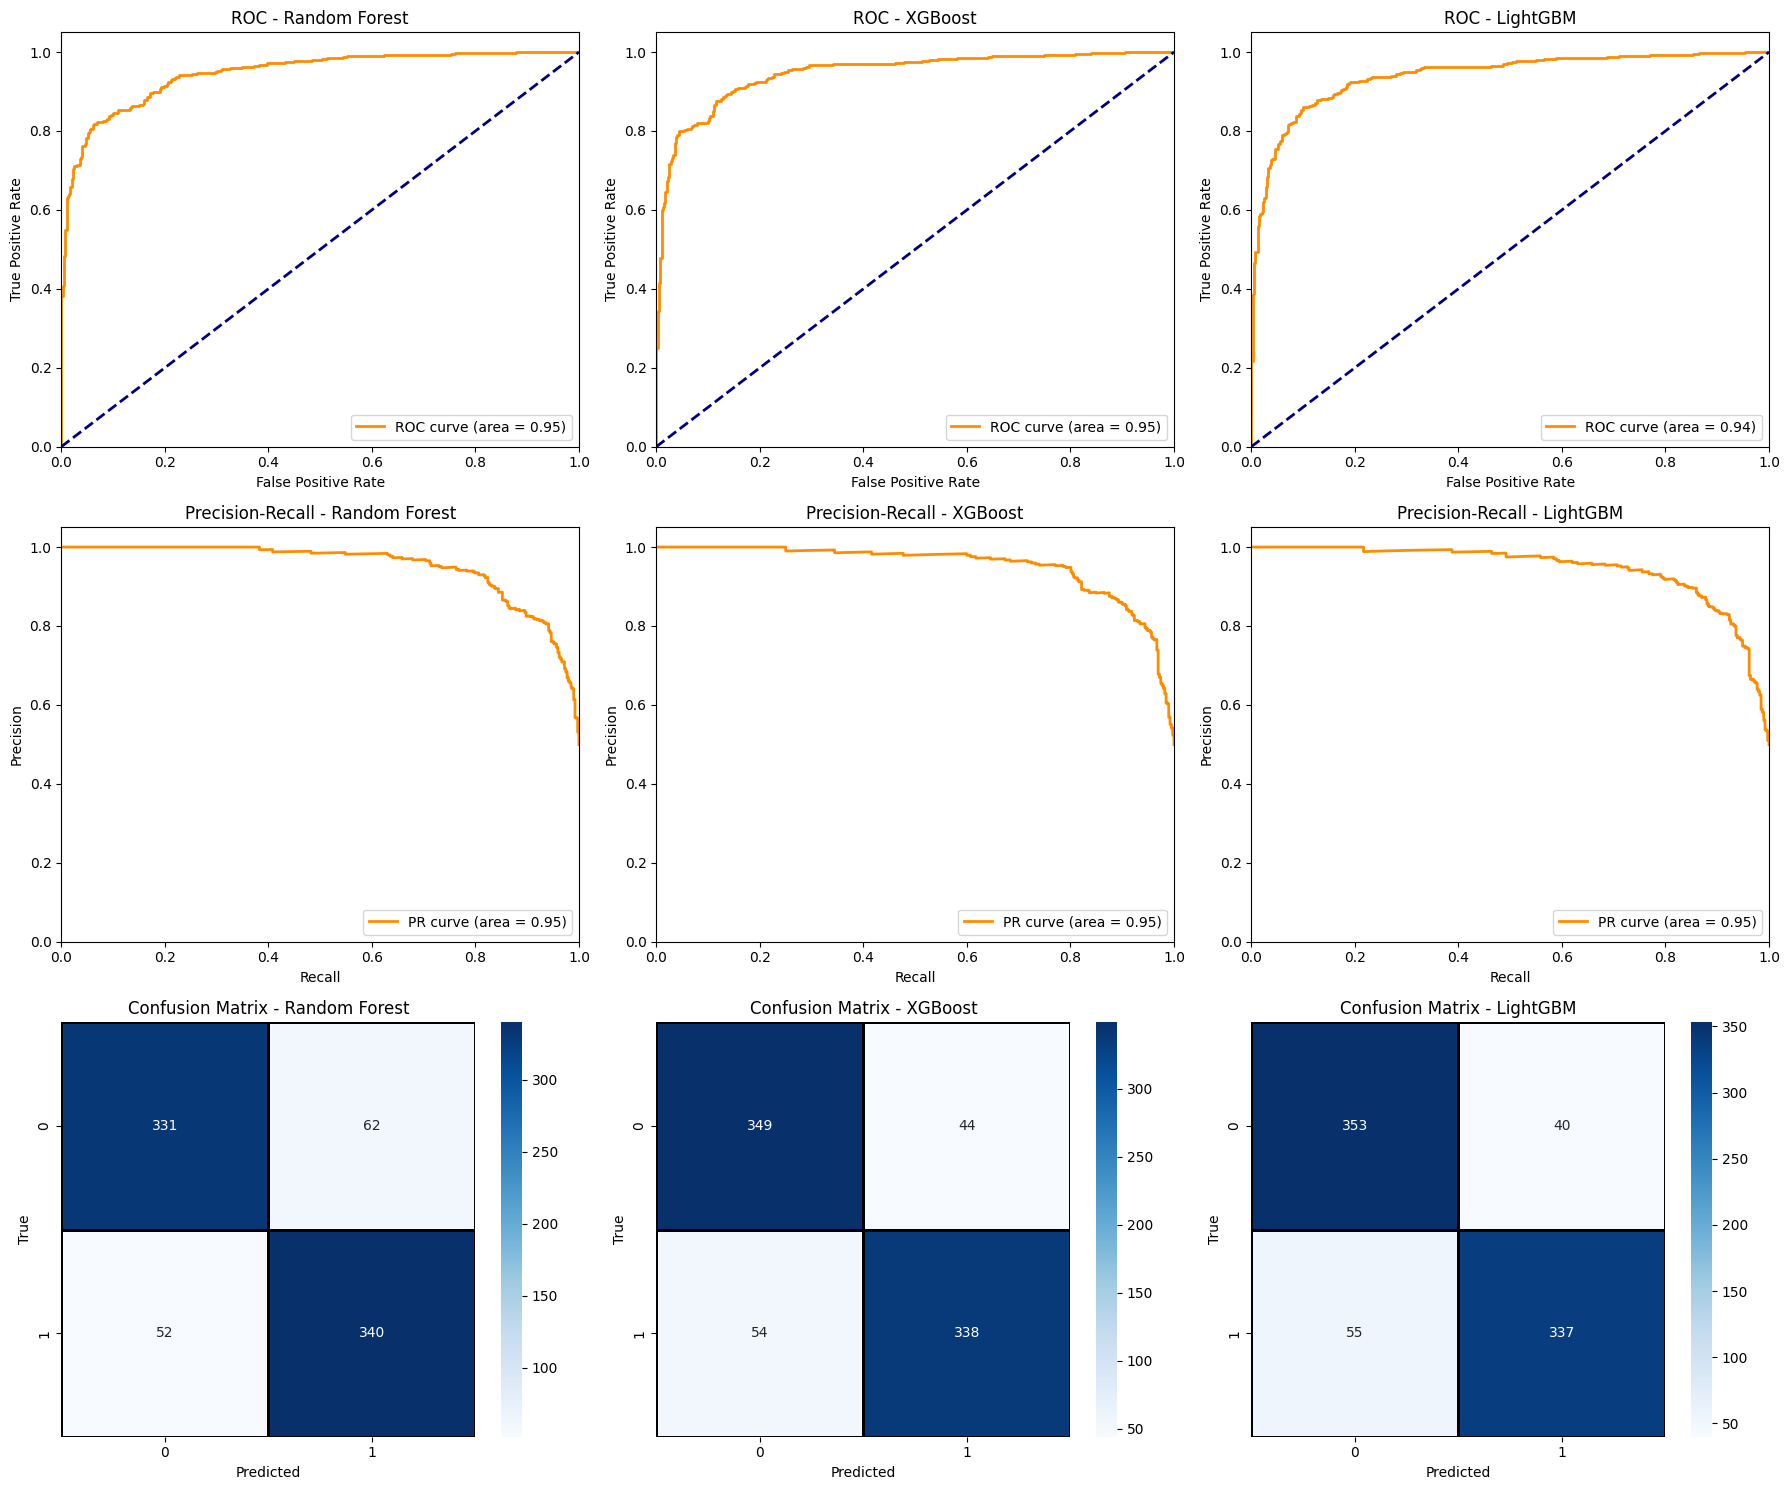

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.8547770700636943, 'Precision': 0.845771144278607, 'Recall': 0.8673469387755102, 'F1 Score': 0.8564231738035265, 'ROC AUC': 0.9457210365062054}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.8751592356687898, 'Precision': 0.8848167539267016, 'Recall': 0.8622448979591837, 'F1 Score': 0.8733850129198967, 'ROC AUC': 0.9464805005971854}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.8789808917197452, 'Precision': 0.8938992042440318, 'Recall': 0.8596938775510204, 'F1 Score': 0.8764629388816645, 'ROC AUC': 0.9398595315988991}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.8789808917197452,
 'Precision': 0.8938992042440318,
 'Recall': 0.8596938775510204,
 'F1 Score': 0.8764629388816645,
 'ROC AUC': 0.9398595315988991}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: LightGBM with Accuracy: 0.8790


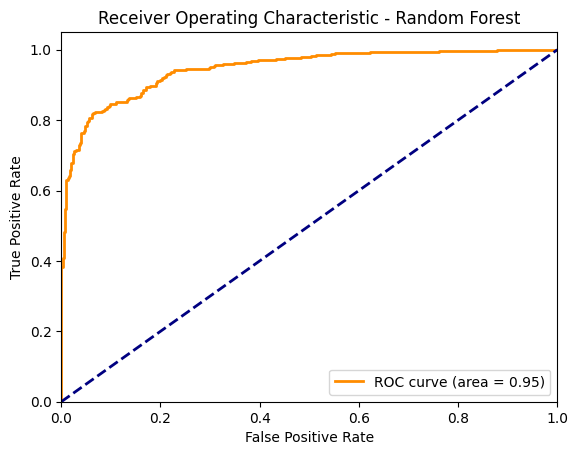

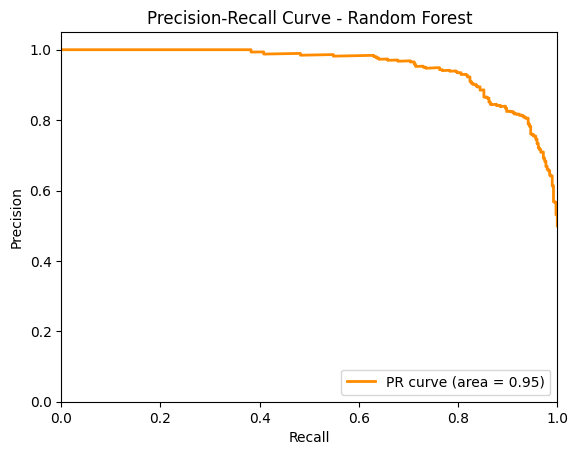

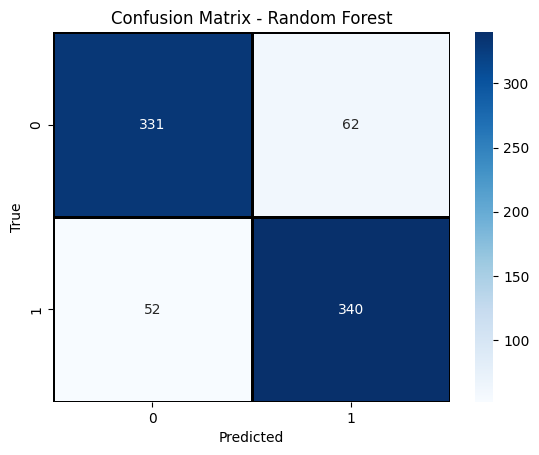

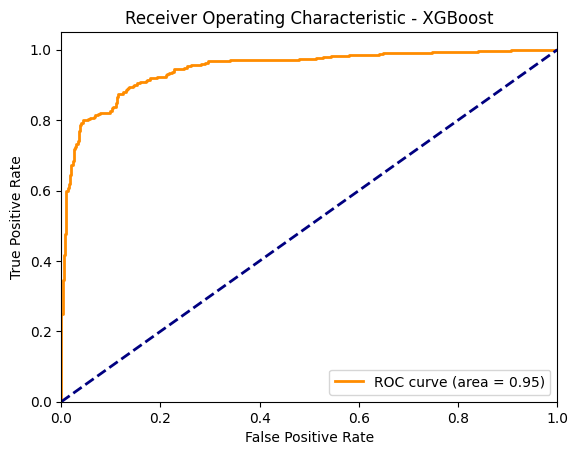

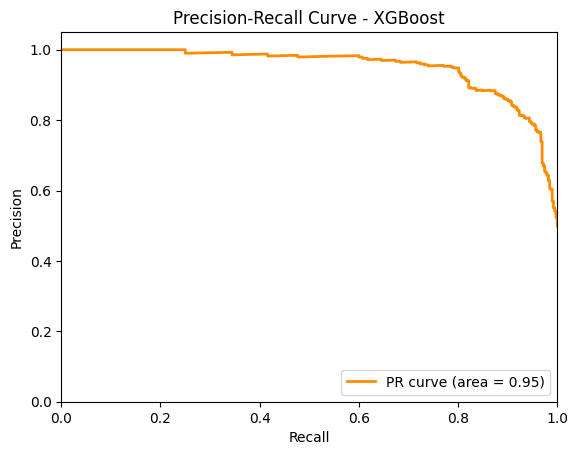

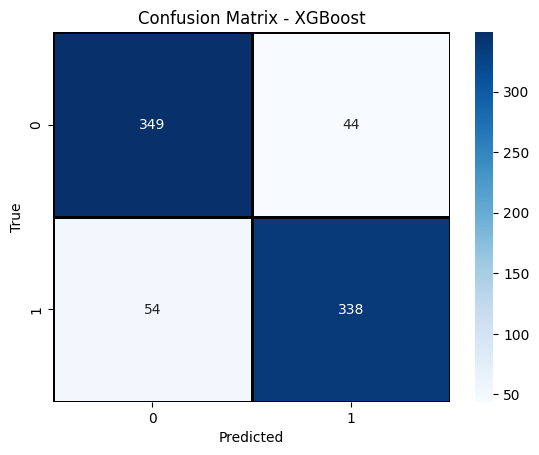

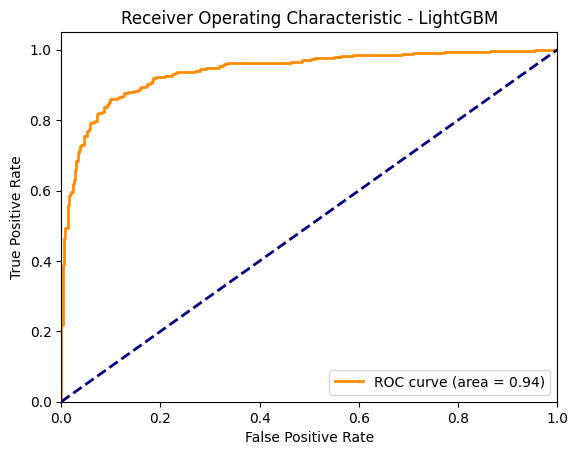

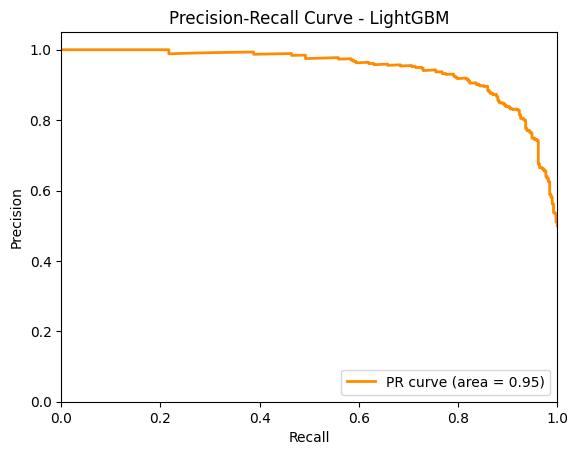

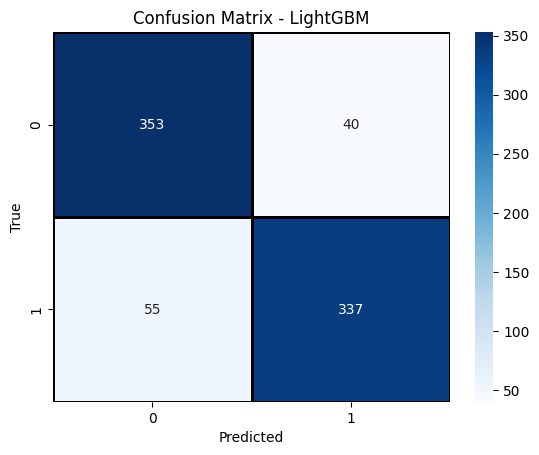

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

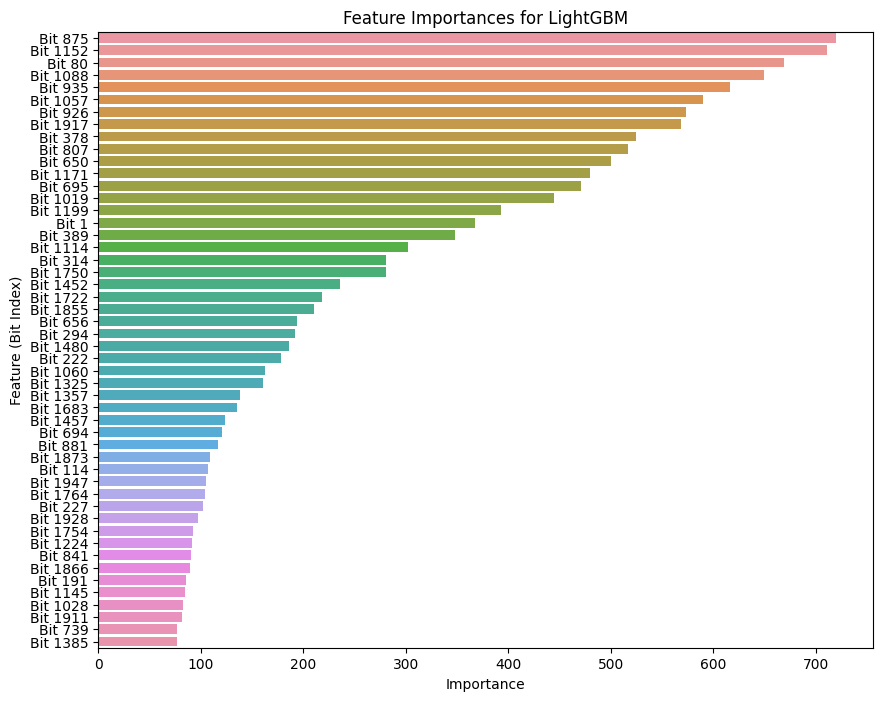

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
